In [4]:
#Remember to restart runtime after installation
!pip install scvi-tools --quiet
!pip install pynndescent --quiet
!pip install scanpy --quiet
!pip install leidenalg --quiet
!pip install pygments==2.14.0 --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import anndata
import scvi
import scanpy as sc
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import warnings

# Define directory locations (Change according to folder structure preferred)
mainDir = r"drive/MyDrive/Isaac_Ang_Shared_Folder/" #change this line to your folder structure
dataDir = ''.join([mainDir, 'data/'])
rawDir = ''.join([dataDir, 'raw/'])
processedDir = ''.join([dataDir, 'processed/'])

# Set settings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 1
sc.set_figure_params(figsize=(6,6), frameon=False)
sc.settings.n_jobs=2
sc.settings.figdir = ''.join([mainDir, 'figures/'])

/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [7]:
#%% Load data
tabula_file = ''.join([processedDir, 'TS_log1p_unscaled_scvi_Blood.h5ad'])
tabula = sc.read_h5ad(tabula_file)

#Filter cells
sc.pp.filter_cells(tabula, min_genes = 10)

In [9]:
tabula.obs['cell_type'].value_counts()


monocyte                                                       8430
neutrophil                                                     8311
classical monocyte                                             6997
mature NK T cell                                               2871
CD4-positive, alpha-beta T cell                                2364
naive B cell                                                   2054
CD8-positive, alpha-beta cytokine secreting effector T cell    1477
CD8-positive, alpha-beta T cell                                1229
CD4-positive, alpha-beta memory T cell                          852
memory B cell                                                   792
type I NK T cell                                                498
macrophage                                                      488
plasma cell                                                     485
naive thymus-derived CD4-positive, alpha-beta T cell            402
erythrocyte                                     

In [10]:
scvi.model.SCVI.setup_anndata( # no batch specified
  tabula, layer = "decontXcounts"
)

In [11]:
def run_scvi(
    tabula,
    n_latent=50,
    n_layers=3,
    dropout_rate=0.1,
    dispersion="gene",
    max_epochs=100,
    batch_size=1024,
    obsm_latent_key="X_scvi",
):
  model = scvi.model.SCVI(
      tabula,
      n_latent=n_latent,
      n_layers=n_layers,
      dropout_rate=dropout_rate,
      dispersion=dispersion,
      use_layer_norm="both",
      use_batch_norm="none",
      encode_covariates=True,
  )

  model.train(max_epochs=100, train_size=1.0, batch_size=batch_size)
  tabula.obsm[obsm_latent_key] = model.get_latent_representation(tabula)

In [ ]:
#Change Runtime type to GPU for faster convergence
run_scvi(
    tabula,
    max_epochs = None, # calculates based off # cells
    n_latent = 50,
    dropout_rate = 0.1,
    dispersion = "gene-batch", # splits by batch if batch_key in setup_anndata exists
    obsm_latent_key = 'X_scvi', # store results in a new column called X_scvi
)

In [13]:
sc.pp.neighbors(tabula, use_rep='X_scvi', method='umap', n_neighbors=15) # get connectivities between data points
sc.tl.umap(tabula)

In [19]:
remap_cat_dict = {
    'CD141-positive myeloid dendritic cell': 'dendritic cell',
    'CD4-positive, alpha-beta T cell': 'T cell',
    'CD4-positive, alpha-beta memory T cell': 'T cell',
    'CD8-positive, alpha-beta T cell': 'T cell',
    'CD8-positive, alpha-beta cytokine secreting effector T cell': 'T cell',
    'T cell': 'T cell',
    'basophil': 'basophil',
    'classical monocyte': 'monocyte',
    'monocyte' : 'monocyte',
    'common myeloid progenitor': 'common myeloid progenitor',
    'hematopoietic stem cell': 'hematopoietic stem cell',
    'macrophage': 'macrophage',
    'mature NK T cell': 'NK T cell',
    'memory B cell': 'B cell',
    'naive B cell': 'B cell',
    'naive thymus-derived CD4-positive, alpha-beta T cell': 'T cell',
    'neutrophil': 'neutrophil',
    'non-classical monocyte': 'monocyte',
    'plasma cell':  'plasma cell',
    'plasmablast': 'plasma cell',
    'plasmacytoid dendritic cell': 'dendritic cell',
    'type I NK T cell': 'NK T cell',
    'erythrocyte': 'erythrocyte',
    'platelet': 'platelet'
     }

tabula.obs['cell_type_cons']=tabula.obs['cell_type'].copy()

tabula.obs['cell_type_cons'] = tabula.obs['cell_type_cons'].map(remap_cat_dict).astype('category')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


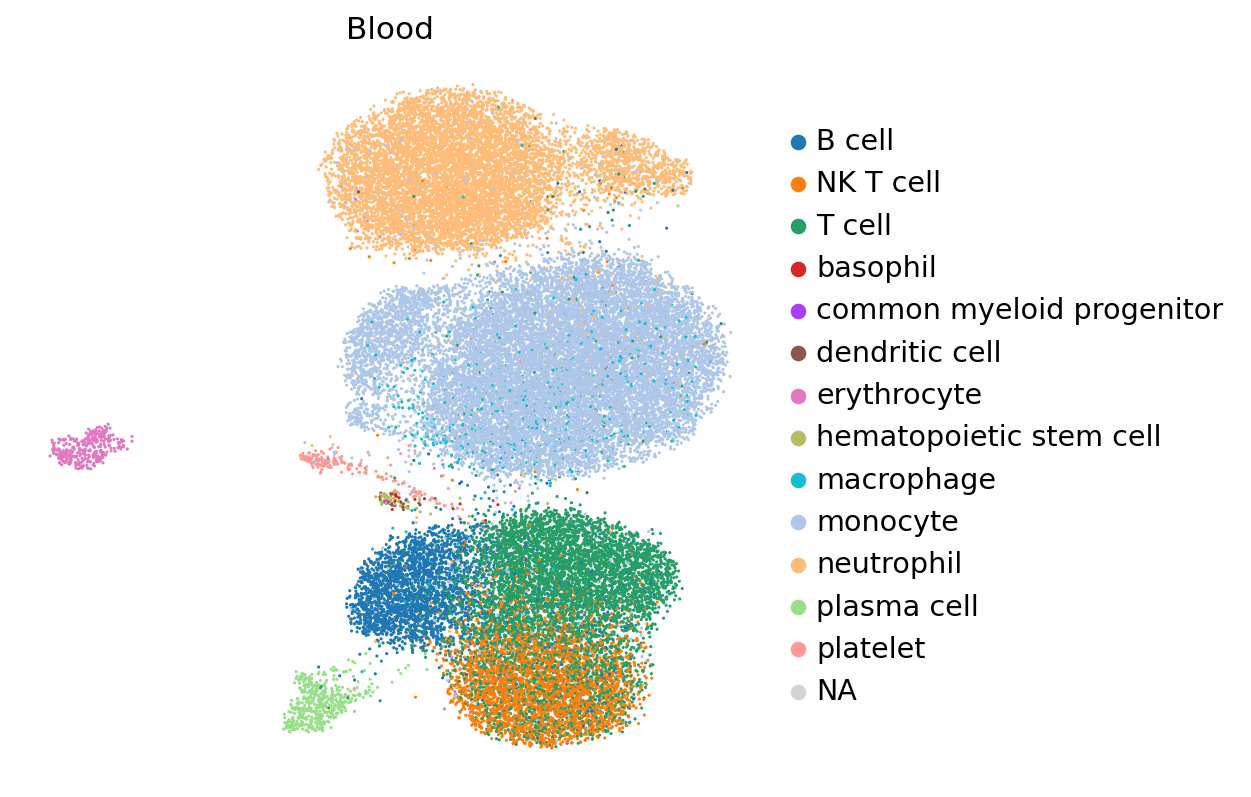

In [21]:
with rc_context({'figure.figsize': (6, 6)}):
  sc.pl.umap(tabula, color="cell_type_cons", size=8, title = "Blood", save="_blood+_10x.png")

In [ ]:
tabula.write_h5ad(''.join([processedDir, 'paper/TS_scvi_blood_glyco.h5ad']))